In [1]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
import deepretina.visualizations as viz
from deepretina.preprocessing import datagen, loadexpt
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.optimize import minimize
from numpy.linalg import norm
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


In [2]:
architecture_filename = 'architecture.json'
whitenoise_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-08 15.42.33 convnet/')
whitenoise_weight_filename = 'epoch018_iter01300_weights.h5' # .63 cc on held-out
naturalscenes_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-07 16.52.44 convnet/')
naturalscenes_weight_filename = 'epoch038_iter02700_weights.h5' # .53 cc on held-out

### White noise model

In [3]:
whitenoise_architecture_data = open(whitenoise_data_dir + architecture_filename, 'r')
whitenoise_architecture_string = whitenoise_architecture_data.read()
whitenoise_model = model_from_json(whitenoise_architecture_string)
whitenoise_model.load_weights(whitenoise_data_dir + whitenoise_weight_filename)

In [4]:
whitenoise_weights = h5py.File(whitenoise_data_dir + whitenoise_weight_filename, 'r')
list(whitenoise_weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

### Natural scenes model

In [5]:
naturalscenes_architecture_data = open(naturalscenes_data_dir + architecture_filename, 'r')
naturalscenes_architecture_string = naturalscenes_architecture_data.read()
naturalscenes_model = model_from_json(naturalscenes_architecture_string)
naturalscenes_model.load_weights(naturalscenes_data_dir + naturalscenes_weight_filename)

In [6]:
naturalscenes_weights = h5py.File(naturalscenes_data_dir + naturalscenes_weight_filename, 'r')
list(naturalscenes_weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

## Define activations of affine units

In [7]:
layer_id = 3

In [8]:
whitenoise_3rd_layer_output = theano.function([whitenoise_model.layers[0].input], 
                                              whitenoise_model.layers[layer_id].get_output(train=False))

In [9]:
naturalscenes_3rd_layer_output = theano.function([naturalscenes_model.layers[0].input], 
                                              naturalscenes_model.layers[layer_id].get_output(train=False))

## STAs

In [15]:
blah = whitenoise_3rd_layer_output(np.random.randn(2,40,50,50).astype('float32'))

In [16]:
blah.shape

(2, 16)

In [29]:
nsamples = 1000
batch_size = 50
n_interunits = 16
#whitenoise_stas = [np.zeros((40,50,50), dtype='float32') for _ in range(n_interunits)]
#naturalscenes_stas = [np.zeros((40,50,50), dtype='float32') for _ in range(n_interunits)]
for iteration in range(nsamples):
    sample = np.random.randn(batch_size, 40, 50, 50).astype('float32')
    whitenoise_response = whitenoise_3rd_layer_output(sample) # batch_size x n_interunits
    naturalscenes_response = naturalscenes_3rd_layer_output(sample)
    
    whitenoise_sta = np.tensordot(whitenoise_response.T, sample, axes=1)
    naturalscenes_sta = np.tensordot(naturalscenes_response.T, sample, axes=1)
    for n in range(n_interunits):
        whitenoise_stas[n] += whitenoise_sta[n]
        naturalscenes_stas[n] += naturalscenes_sta[n]

## Visualize White Noise STAs

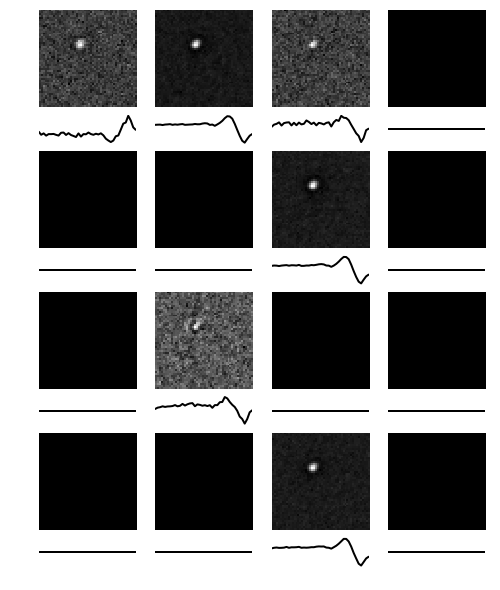

In [37]:
whitenoise_spatial_profiles = []

fig = plt.gcf()
fig.set_size_inches((8,10))
plt.title('Whitenoise Affine STAs', fontsize=20)
num_cols = int(np.sqrt(n_interunits))
num_rows = int(np.ceil(n_interunits/num_cols))
idxs = range(num_cols)
for x in range(num_cols):
    for y in range(num_rows):
        plt_idx = y * num_cols + x + 1
        spatial,temporal = ft.decompose(whitenoise_stas[plt_idx-1])
        whitenoise_spatial_profiles.append(spatial)
        #plt.subplot(num_rows, num_cols, plt_idx)
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y, x), rowspan=3)
        ax.imshow(spatial, interpolation='nearest', cmap='gray') #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')

        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y+3, x), rowspan=1)
        ax.plot(np.linspace(0,400,40), temporal, 'k', linewidth=2)
        plt.grid('off')
        plt.axis('off')


In [35]:
whitenoise_weights['layer_4']['param_0'][:].reshape((4,4))

array([[-0.19575298,  0.38133672,  0.18540654,  0.0006661 ],
       [ 0.00723252,  0.03393508,  0.45568955,  0.0278566 ],
       [-0.0235226 ,  0.13088673,  0.00427534, -0.06351989],
       [ 0.00913144,  0.00118824,  0.62962162,  0.06962863]], dtype=float32)

#### Overlap of whitenoise STAs

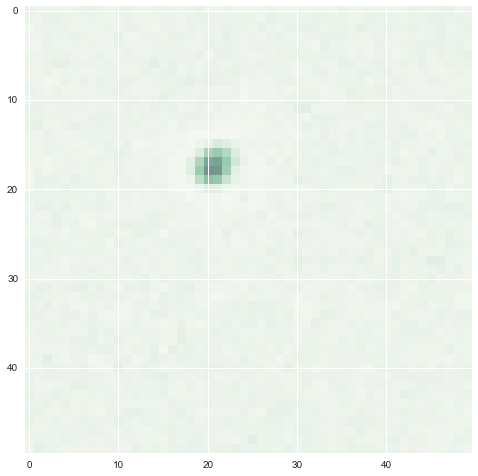

In [52]:
# 0, 1, 2, 9, 14
plt.imshow(whitenoise_spatial_profiles[0], cmap='Blues', alpha=.4)
plt.imshow(whitenoise_spatial_profiles[1], cmap='Oranges', alpha=.4)
plt.imshow(whitenoise_spatial_profiles[9], cmap='Greens', alpha=.4)

## Visualize Natural Scenes STAs

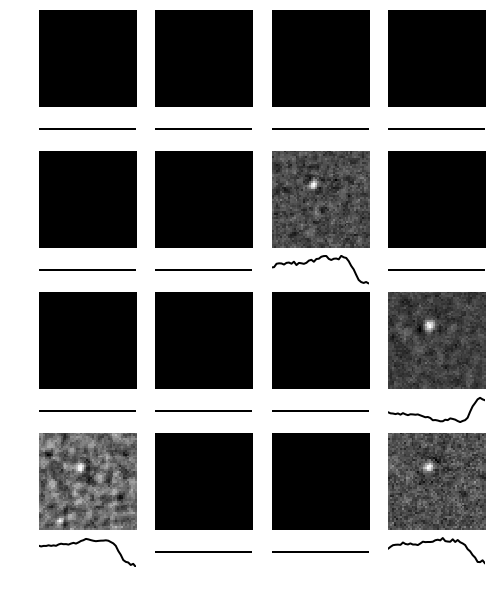

In [38]:
naturalscenes_spatial_profiles = []

fig = plt.gcf()
fig.set_size_inches((8,10))
plt.title('Natural Scenes Affine STAs', fontsize=20)
num_cols = int(np.sqrt(n_interunits))
num_rows = int(np.ceil(n_interunits/num_cols))
idxs = range(num_cols)
for x in range(num_cols):
    for y in range(num_rows):
        plt_idx = y * num_cols + x + 1
        spatial,temporal = ft.decompose(naturalscenes_stas[plt_idx-1])
        naturalscenes_spatial_profiles.append(spatial)
        #plt.subplot(num_rows, num_cols, plt_idx)
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y, x), rowspan=3)
        ax.imshow(spatial, interpolation='nearest', cmap='gray') #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')

        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y+3, x), rowspan=1)
        ax.plot(np.linspace(0,400,40), temporal, 'k', linewidth=2)
        plt.grid('off')
        plt.axis('off')


In [36]:
naturalscenes_weights['layer_4']['param_0'][:].reshape((4,4))

array([[-0.04348507, -0.00182406,  0.62401438, -0.01669533],
       [ 0.20434456,  0.28400692,  0.41163233,  0.47549644],
       [ 0.02399726, -0.39117765, -0.0046621 , -0.17514187],
       [ 0.46752766,  0.54324675,  0.22208178,  0.24756294]], dtype=float32)

#### Overlap of natural scenes STAs

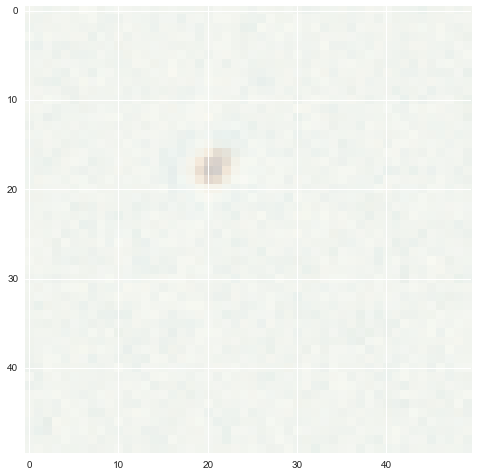

In [54]:
# 6, 11, 12, 15
plt.imshow(whitenoise_spatial_profiles[6], cmap='Blues', alpha=.4)
plt.imshow(whitenoise_spatial_profiles[11], cmap='Oranges', alpha=.4)
plt.imshow(whitenoise_spatial_profiles[12], cmap='Greens', alpha=.4)
plt.imshow(whitenoise_spatial_profiles[15], cmap='Greens', alpha=.4)

# Visualize Affine interunit receptive field component of full model

## White noise

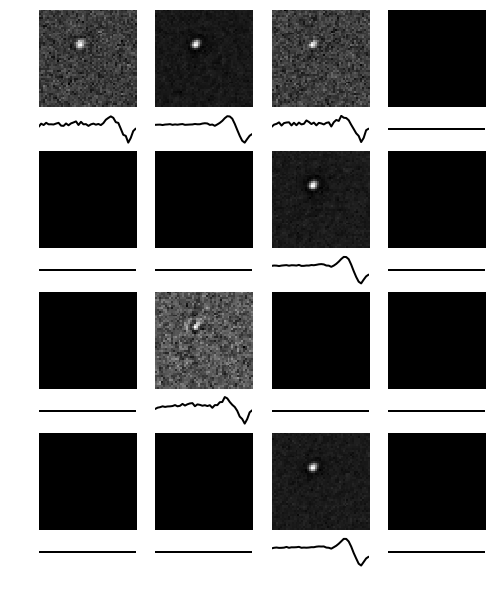

In [57]:
whitenoise_spatial_profiles = []

fig = plt.gcf()
fig.set_size_inches((8,10))
plt.title('Whitenoise Affine STAs', fontsize=20)
num_cols = int(np.sqrt(n_interunits))
num_rows = int(np.ceil(n_interunits/num_cols))
idxs = range(num_cols)
for x in range(num_cols):
    for y in range(num_rows):
        plt_idx = y * num_cols + x + 1
        spatial,temporal = ft.decompose(whitenoise_stas[plt_idx-1] * whitenoise_weights['layer_4']['param_0'][plt_idx-1][0])
        whitenoise_spatial_profiles.append(spatial)
        #plt.subplot(num_rows, num_cols, plt_idx)
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y, x), rowspan=3)
        ax.imshow(spatial, interpolation='nearest', cmap='gray') #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')

        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y+3, x), rowspan=1)
        ax.plot(np.linspace(0,400,40), temporal, 'k', linewidth=2)
        plt.grid('off')
        plt.axis('off')


## Natural Scenes

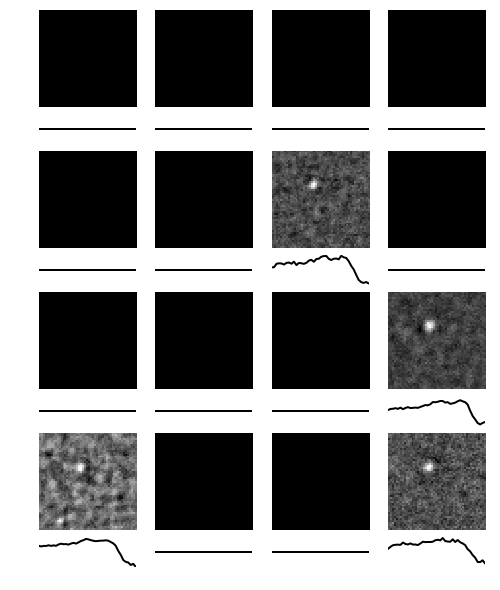

In [58]:
naturalscenes_spatial_profiles = []

fig = plt.gcf()
fig.set_size_inches((8,10))
plt.title('Natural Scenes Affine STAs', fontsize=20)
num_cols = int(np.sqrt(n_interunits))
num_rows = int(np.ceil(n_interunits/num_cols))
idxs = range(num_cols)
for x in range(num_cols):
    for y in range(num_rows):
        plt_idx = y * num_cols + x + 1
        spatial,temporal = ft.decompose(naturalscenes_stas[plt_idx-1] * naturalscenes_weights['layer_4']['param_0'][plt_idx-1][0])
        naturalscenes_spatial_profiles.append(spatial)
        #plt.subplot(num_rows, num_cols, plt_idx)
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y, x), rowspan=3)
        ax.imshow(spatial, interpolation='nearest', cmap='gray') #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')

        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y+3, x), rowspan=1)
        ax.plot(np.linspace(0,400,40), temporal, 'k', linewidth=2)
        plt.grid('off')
        plt.axis('off')


# Do they lay on top of each other?

#### White noise

In [86]:
np.min(whitenoise_spatial_profiles[1])

0.0

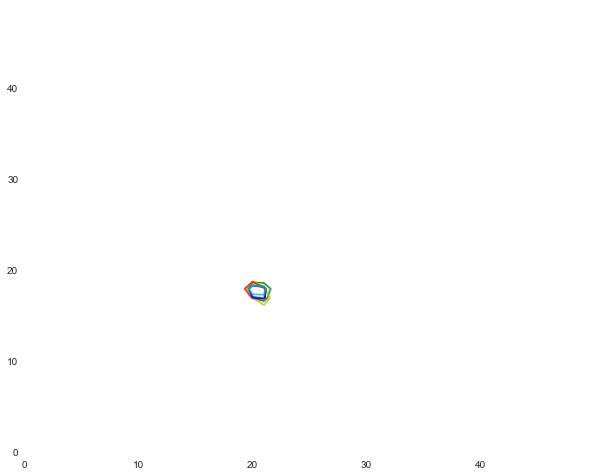

In [91]:
# 0, 1, 2, 9, 14
color = ['g', 'r', 'b', 'k', 'c', 'm', 'y', 'g', 'r', 'b', 'k', 'c', 'm', 'y', 'g', 'r',]
for n in range(16):
    plt.contour(whitenoise_spatial_profiles[n], levels=[np.max(whitenoise_spatial_profiles[n])-0.05],
            colors=color[n], alpha=0.8)

#### Natural scenes

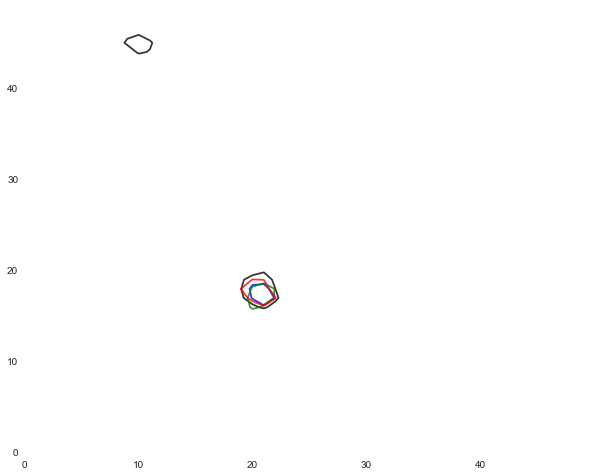

In [93]:
# 0, 1, 2, 9, 14
color = ['g', 'r', 'b', 'k', 'c', 'm', 'y', 'g', 'r', 'b', 'k', 'c', 'm', 'y', 'g', 'r',]
for n in range(16):
    plt.contour(naturalscenes_spatial_profiles[n], levels=[np.max(naturalscenes_spatial_profiles[n])-0.04],
            colors=color[n], alpha=0.8)